In [ ]:
import os
!pip install -q kaggle #import kaggle api

from google.colab import files

if os.path.exists('/content/kaggle.json') == False:
  files.upload()

!cp kaggle.json ~/.kaggle/ #copy kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json #change the permision of the file

#test that everything is running ok
!kaggle datasets download -d grassknoted/asl-alphabet
!unzip asl-alphabet.zip

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1909.jpg  
  inflating: asl_alphabet_tr

In [ ]:
import os #this is here so i dont have to run the first code block everytime collab crashes >:(

import numpy as np
from numpy.random import seed


import cv2 #for reading images using path

from sklearn.model_selection import train_test_split #test train split
from sklearn.utils import shuffle #shuffle data

import matplotlib.pyplot as plt #for plotting & data visualization

import tensorflow as tf #for building the model

#for building a CNN using keras
from tensorflow import keras
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, Dropout
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
#for error analysis
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.metrics import ConfusionMatrixDisplay

# Data Preprocessing


In [ ]:
features = []
labels = []

classes = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z","del","nothing","space"]
base_path = "/content/asl_alphabet_train/asl_alphabet_train/"


# create a path that represents each class directory
for i in range(len(classes)):
  path = base_path + classes[i]
  dir_list = os.listdir(path)

  #append path to features list and appent classification to labels list
  for item in range(500):
    features.append(base_path + classes[i] + "/" + dir_list[item])
    labels.append([i])

#print list sizes
print("Feature size: ", len(features))
print("Labels size: ", len(labels))

Feature size:  14500
Labels size:  14500


In [ ]:
features,labels = shuffle(features,labels,random_state=0)

# Splitting data into train/test

In [ ]:
x_train, y_train, x_test, y_test = [], [], [], []

#use cv2 to read image features and then reshape image to 200 x 200 x 3.
for i in features:
    x_train.append(cv2.imread(i,cv2.IMREAD_COLOR))
    x_train[-1] = np.reshape(x_train[-1],[200,200,3])

#append labels to y_train
for i in labels:
    y_train.append(i)

x_train,x_test,y_train,y_test = train_test_split(x_train,y_train,test_size=0.3)

#print shapes
print('x_train shape: ', np.shape(x_train))
print('y_train shape: ', np.shape(y_train))
print('x_test shape: ', np.shape(x_test))
print('y_test shape: ', np.shape(y_test))

x_train shape:  (10150, 200, 200, 3)
y_train shape:  (10150, 1)
x_test shape:  (4350, 200, 200, 3)
y_test shape:  (4350, 1)


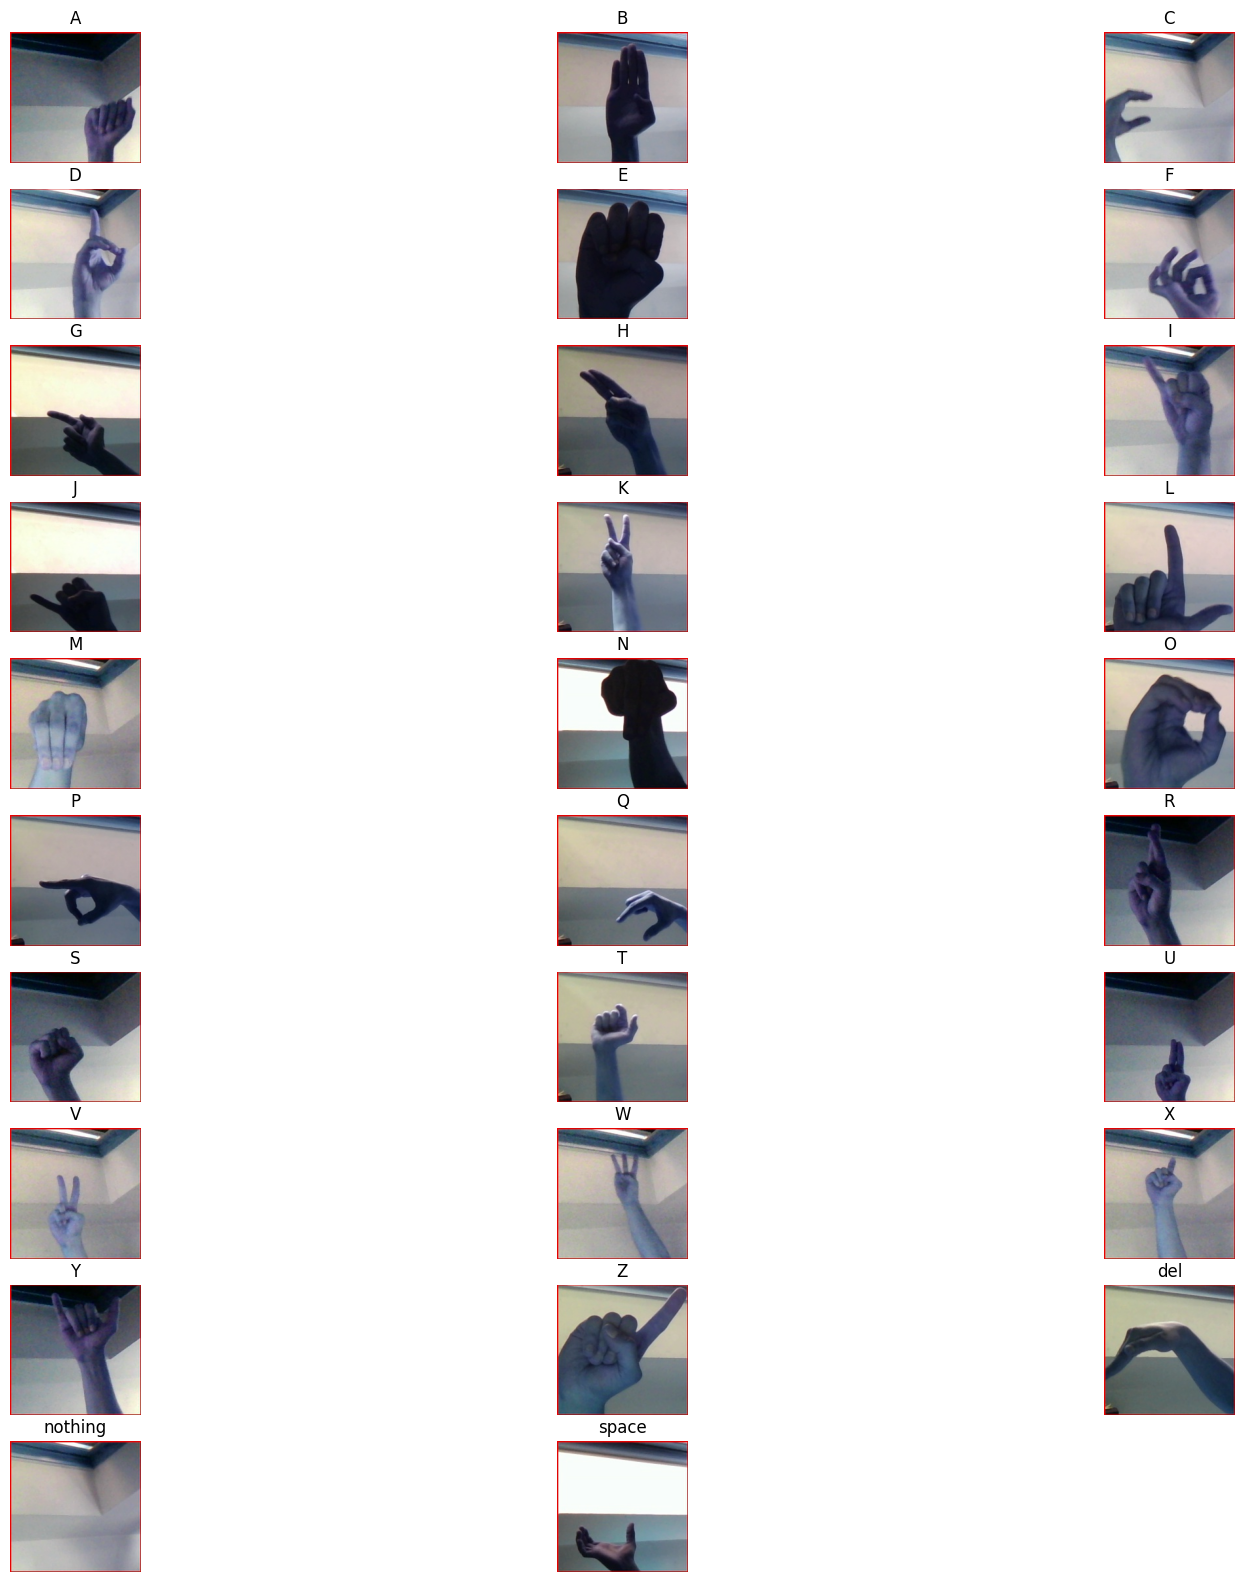

In [ ]:
unique,count = np.unique(y_train,return_counts=True)
num_count = 1
plt.figure(figsize=(20,20))

#print an image of each unique label
for i in unique:
    plt.subplot(10,3,num_count)
    plt.imshow(x_train[np.where(y_train == np.array(i))[0][0]])
    plt.axis('off')
    plt.title(classes[i])
    num_count += 1

Text(0.5, 1.0, 'Image count')

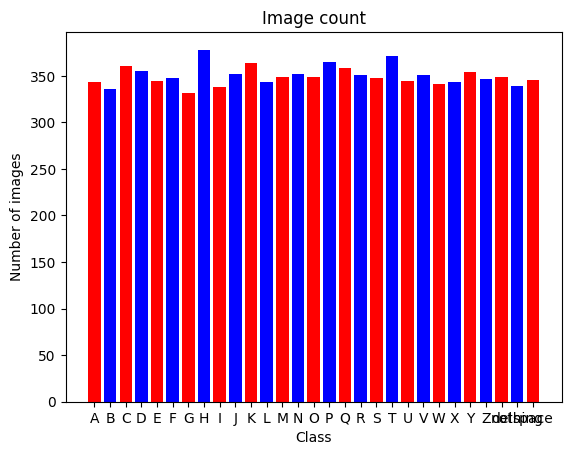

In [ ]:
plt.bar(unique, count, tick_label = classes, width = 0.8, color =['red', 'blue'])
#naming the x-axis
plt.xlabel('Class')
#naming the y-axis
plt.ylabel('Number of images')
#title
plt.title('Image count')

In [ ]:
total_count = sum(count)

for un in unique:
  print('Class: ', classes[un], 'Count: ', count[un], 'Mean Probability: ', count[un]/total_count)

Class:  A Count:  343 Mean Probability:  0.03379310344827586
Class:  B Count:  336 Mean Probability:  0.03310344827586207
Class:  C Count:  361 Mean Probability:  0.035566502463054185
Class:  D Count:  355 Mean Probability:  0.034975369458128076
Class:  E Count:  344 Mean Probability:  0.033891625615763546
Class:  F Count:  348 Mean Probability:  0.03428571428571429
Class:  G Count:  332 Mean Probability:  0.03270935960591133
Class:  H Count:  378 Mean Probability:  0.037241379310344824
Class:  I Count:  338 Mean Probability:  0.03330049261083744
Class:  J Count:  352 Mean Probability:  0.03467980295566502
Class:  K Count:  364 Mean Probability:  0.03586206896551724
Class:  L Count:  343 Mean Probability:  0.03379310344827586
Class:  M Count:  349 Mean Probability:  0.03438423645320197
Class:  N Count:  352 Mean Probability:  0.03467980295566502
Class:  O Count:  349 Mean Probability:  0.03438423645320197
Class:  P Count:  365 Mean Probability:  0.03596059113300493
Class:  Q Count:  35

# Experiment 1

In [ ]:
def cnn_model():
    inputs = Input(shape=(200, 200, 3))
    x = Conv2D(16, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((3, 3))(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D((3, 3))(x)
    x = Flatten()(x)
    outputs = Dense(29, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    opt = Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

model = cnn_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 198, 198, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 66, 66, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 21, 21, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14112)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 29)                  │         409,277 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 414,365 (1.58 MB)

 Trainable params: 414,365 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#turn our lists into numpy arrays so we can insert them into our model
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

# adding a checkpoint to save the best model
modelcheckpoint  = ModelCheckpoint(filepath="CNN_experiment_1.keras",save_best_only=True, monitor="val_loss")
callback_list    = [modelcheckpoint]

#start fitting our model
history = model.fit(x_train,
          y_train,
          epochs=10,
          validation_data = (x_test,y_test),
          callbacks = callback_list)

Epoch 1/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.1286 - loss: 58.4683 - val_accuracy: 0.4430 - val_loss: 2.0345
Epoch 2/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5806 - loss: 1.4262 - val_accuracy: 0.5644 - val_loss: 1.5024
Epoch 3/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.7686 - loss: 0.7371 - val_accuracy: 0.6566 - val_loss: 1.3083
Epoch 4/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.8412 - loss: 0.4814 - val_accuracy: 0.6940 - val_loss: 1.3386
Epoch 5/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8771 - loss: 0.3718 - val_accuracy: 0.6892 - val_loss: 1.4577
Epoch 6/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8839 - loss: 0.3447 - val_accuracy: 0.6929 - val_loss: 1.4925
Epoch 7/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9043 - loss: 0.2939 - val_accuracy: 0.7172 - val_loss: 1.4732
Epoch 8/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9285 - loss: 0.2084 - val_ac

In [ ]:
test_model = keras.models.load_model('CNN_experiment_1.keras')
test_model.evaluate(x_test, y_test)

136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6506 - loss: 1.3713


[1.3082536458969116, 0.656551718711853]

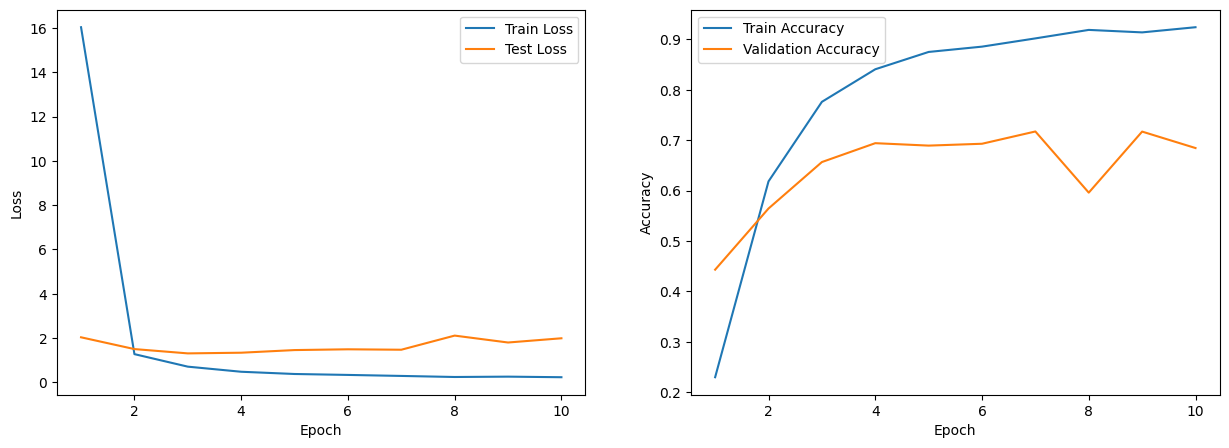

In [ ]:
#get values from history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

#create a count for the number of epochs (x axis)
epoch_count = range(1, len(loss) + 1)

#train and test loss plot
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epoch_count, loss)
plt.plot(epoch_count, val_loss)
plt.legend(['Train Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

#train and val acc plot
plt.subplot(1,2,2)
plt.plot(epoch_count, accuracy)
plt.plot(epoch_count, val_accuracy)
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In the second experiment we will add some regularization to see if that improves the accuracy. We can also increase the model complexity by adding layers or changing params. ChatGPT suggested we use ImageDataGenerator from keras to apply transformations to the data to see how that effects the accuracy.

# Experiment #2

In [ ]:
def cnn_model_dropout():
    inputs = Input(shape=(200, 200, 3))
    x = Conv2D(16, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((3, 3))(x)
    x = Dropout(0.25)(x)  # Dropout after pooling
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D((3, 3))(x)
    x = Dropout(0.25)(x)  # Dropout after pooling
    x = Flatten()(x)
    x = Dropout(0.5)(x)  # Dropout before fully connected layer
    outputs = Dense(29, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

model_dropout = cnn_model_dropout()
model_dropout.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 198, 198, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 66, 66, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 66, 66, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 21, 21, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 21, 21, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 14112)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 14112)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 29)                  │         409,277 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 414,365 (1.58 MB)

 Trainable params: 414,365 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# adding a checkpoint to save the best model
modelcheckpoint  = ModelCheckpoint(filepath="CNN_experiment_2.keras",save_best_only=True, monitor="val_loss")
callback_list    = [modelcheckpoint]

#start fitting our model
history = model_dropout.fit(x_train,
          y_train,
          epochs=50,
          validation_data = (x_test,y_test),
          callbacks = callback_list)

Epoch 1/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.0396 - loss: 137.3543 - val_accuracy: 0.0393 - val_loss: 3.4936
Epoch 2/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.0371 - loss: 8.5863 - val_accuracy: 0.0389 - val_loss: 3.3910
Epoch 3/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.0368 - loss: 4.0796 - val_accuracy: 0.0320 - val_loss: 3.3729
Epoch 4/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.0370 - loss: 3.6433 - val_accuracy: 0.0294 - val_loss: 3.3679
Epoch 5/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.0332 - loss: 3.4473 - val_accuracy: 0.0301 - val_loss: 3.3664
Epoch 6/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.0401 - loss: 3.4050 - val_accuracy: 0.0303 - val_loss: 3.3664
Epoch 7/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.0413 - loss: 3.3829 - val_accuracy: 0.0287 - val_loss: 3.3653
Epoch 8/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.0430 - loss: 3.3689 - val_a

In [ ]:
test_model = keras.models.load_model('CNN_experiment_2.keras')
test_model.evaluate(x_test, y_test)

136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8467 - loss: 0.5717


[0.576999843120575, 0.8464367985725403]

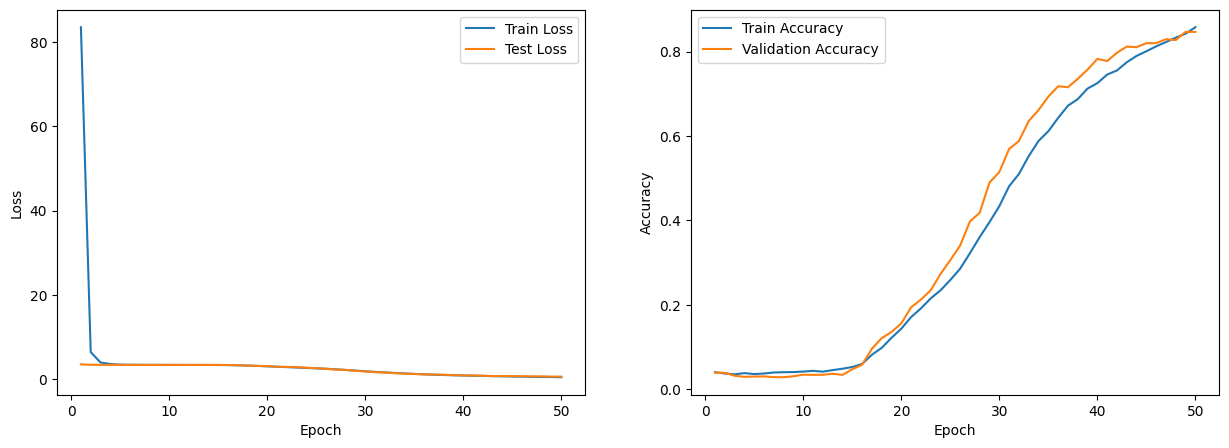

In [ ]:
#get values from history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

#create a count for the number of epochs (x axis)
epoch_count = range(1, len(loss) + 1)

#train and test loss plot
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epoch_count, loss)
plt.plot(epoch_count, val_loss)
plt.legend(['Train Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

#train and val acc plot
plt.subplot(1,2,2)
plt.plot(epoch_count, accuracy)
plt.plot(epoch_count, val_accuracy)
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

The model is performing very well in the second experiemnt, but we wanted to try adding/changing somethings to try and improve it's performance even more. First, we added batch normalization after each convolution layer, which was suggested by ChatGPT. This helps to normalize the activations which makes the training more stable and improves generalization. We also added dropout and increase the complexity by adding an extra convolutional block.

# Accuracy on test data

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Preprocess an individual image
def preprocess_image(image_path, target_size=(200, 200)):
    # Use OpenCV to load the image in BGR format
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, target_size)  # Resize to 200x200
    img = img.astype("float32")  # Ensure float for compatibility
    img_array = np.expand_dims(img, axis=0)  # Add batch dimension
    return img_array

# Predict the class of an image
def predict_image(model, image_path, class_labels):
    img_array = preprocess_image(image_path)
    predictions = model.predict(img_array, verbose=0)
    predicted_class = class_labels[np.argmax(predictions)]
    return predicted_class

# Evaluate accuracy on a folder of test images
def evaluate_model_on_folder(model, folder_path, class_labels):
    correct = 0
    total = 0

    for filename in os.listdir(folder_path):
        label = filename.split("_")[0]  # Extract the true label from filename
        file_path = os.path.join(folder_path, filename)
        predicted_label = predict_image(model, file_path, class_labels)

        if label == predicted_label:
            correct += 1
        total += 1
        print(f"File: {filename}, True: {label}, Predicted: {predicted_label}")

    accuracy = correct / total if total > 0 else 0
    print(f"Accuracy: {accuracy * 100:.2f}%")
    return accuracy

test_folder_path = "/content/asl_alphabet_test/asl_alphabet_test"

# Load the trained model
model = keras.models.load_model('CNN_experiment_2.keras')

# Evaluate the model
evaluate_model_on_folder(model, test_folder_path, classes)

File: L_test.jpg, True: L, Predicted: L
File: B_test.jpg, True: B, Predicted: B
File: W_test.jpg, True: W, Predicted: W
File: Z_test.jpg, True: Z, Predicted: Z
File: D_test.jpg, True: D, Predicted: D
File: C_test.jpg, True: C, Predicted: C
File: H_test.jpg, True: H, Predicted: H
File: U_test.jpg, True: U, Predicted: U
File: G_test.jpg, True: G, Predicted: G
File: Q_test.jpg, True: Q, Predicted: Q
File: M_test.jpg, True: M, Predicted: M
File: R_test.jpg, True: R, Predicted: R
File: Y_test.jpg, True: Y, Predicted: Y
File: S_test.jpg, True: S, Predicted: S
File: X_test.jpg, True: X, Predicted: X
File: P_test.jpg, True: P, Predicted: P
File: F_test.jpg, True: F, Predicted: F
File: nothing_test.jpg, True: nothing, Predicted: nothing
File: J_test.jpg, True: J, Predicted: J
File: A_test.jpg, True: A, Predicted: A
File: I_test.jpg, True: I, Predicted: I
File: E_test.jpg, True: E, Predicted: E
File: T_test.jpg, True: T, Predicted: T
File: V_test.jpg, True: V, Predicted: W
File: space_test.jpg, 

0.9642857142857143

# Experiment #3

In [ ]:
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping

def cnn_model():
    inputs = Input(shape=(200, 200, 3))
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(29, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)

    opt = Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

model_batch_norm = cnn_model()
model_batch_norm.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 198, 198, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 198, 198, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 99, 99, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 97, 97, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 97, 97, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 46, 46, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 46, 46, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 23, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 67712)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      17,334,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 29)                  │           7,453 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,436,125 (66.51 MB)

 Trainable params: 17,435,677 (66.51 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
#add checkpoint to save the best model
modelcheckpoint = ModelCheckpoint(filepath="CNN_experiment_3.keras", save_best_only=True, monitor="val_loss")
# early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
callback_list = [modelcheckpoint]#, early_stopping]

#start building and train the model
history = model.fit(x_train, y_train, batch_size=32,
                    epochs=50,
                    validation_data=(x_test, y_test),
                    callbacks=callback_list)

Epoch 1/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.8652 - loss: 0.4101 - val_accuracy: 0.8460 - val_loss: 0.5825
Epoch 2/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8714 - loss: 0.3874 - val_accuracy: 0.8529 - val_loss: 0.5634
Epoch 3/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8763 - loss: 0.3818 - val_accuracy: 0.8676 - val_loss: 0.5240
Epoch 4/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8788 - loss: 0.3612 - val_accuracy: 0.8644 - val_loss: 0.5140
Epoch 5/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.8908 - loss: 0.3311 - val_accuracy: 0.8538 - val_loss: 0.5365
Epoch 6/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8845 - loss: 0.3330 - val_accuracy: 0.8611 - val_loss: 0.5256
Epoch 7/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9053 - loss: 0.2877 - val_accuracy: 0.8598 - val_loss: 0.5253
Epoch 8/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9052 - loss: 0.2906 - val_ac

In [ ]:
# Evaluate the model on the test set
test_model = keras.models.load_model('CNN_experiment_3.keras')
test_model.evaluate(x_test, y_test)

136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9192 - loss: 0.3279


[0.35287532210350037, 0.9121838808059692]

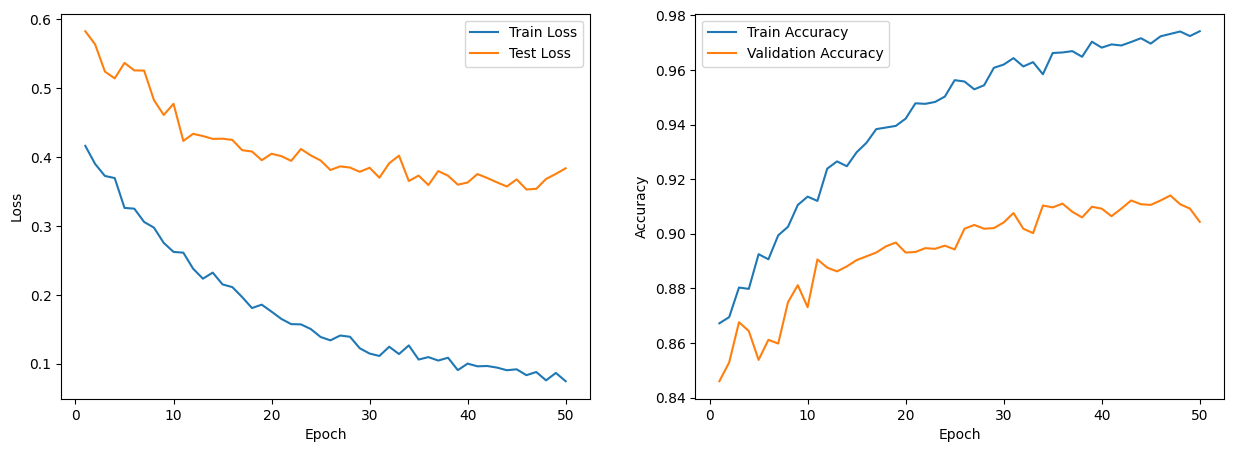

In [ ]:
#get values from history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

#create a count for the number of epochs (x axis)
epoch_count = range(1, len(loss) + 1)

#train and test loss plot
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epoch_count, loss)
plt.plot(epoch_count, val_loss)
plt.legend(['Train Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

#train and val acc plot
plt.subplot(1,2,2)
plt.plot(epoch_count, accuracy)
plt.plot(epoch_count, val_accuracy)
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Accuracy on test data

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Preprocess an individual image
def preprocess_image(image_path, target_size=(200, 200)):
    # Use OpenCV to load the image in BGR format
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, target_size)  # Resize to 200x200
    img = img.astype("float32")  # Ensure float for compatibility
    img_array = np.expand_dims(img, axis=0)  # Add batch dimension
    return img_array

# Predict the class of an image
def predict_image(model, image_path, class_labels):
    img_array = preprocess_image(image_path)
    predictions = model.predict(img_array, verbose=0)
    predicted_class = class_labels[np.argmax(predictions)]
    return predicted_class

# Evaluate accuracy on a folder of test images
def evaluate_model_on_folder(model, folder_path, class_labels):
    correct = 0
    total = 0

    for filename in os.listdir(folder_path):
        label = filename.split("_")[0]  # Extract the true label from filename
        file_path = os.path.join(folder_path, filename)
        predicted_label = predict_image(model, file_path, class_labels)

        if label == predicted_label:
            correct += 1
        total += 1
        print(f"File: {filename}, True: {label}, Predicted: {predicted_label}")

    accuracy = correct / total if total > 0 else 0
    print(f"Accuracy: {accuracy * 100:.2f}%")
    return accuracy

test_folder_path = "/content/asl_alphabet_test/asl_alphabet_test"

# Load the best trained model
model = keras.models.load_model('CNN_experiment_3.keras')

# Evaluate the model
evaluate_model_on_folder(model, test_folder_path, classes)

File: L_test.jpg, True: L, Predicted: L
File: B_test.jpg, True: B, Predicted: B
File: W_test.jpg, True: W, Predicted: W
File: Z_test.jpg, True: Z, Predicted: Z
File: D_test.jpg, True: D, Predicted: D
File: C_test.jpg, True: C, Predicted: C
File: H_test.jpg, True: H, Predicted: H
File: U_test.jpg, True: U, Predicted: U
File: G_test.jpg, True: G, Predicted: G
File: Q_test.jpg, True: Q, Predicted: Q
File: M_test.jpg, True: M, Predicted: M
File: R_test.jpg, True: R, Predicted: R
File: Y_test.jpg, True: Y, Predicted: Y
File: S_test.jpg, True: S, Predicted: S
File: X_test.jpg, True: X, Predicted: X
File: P_test.jpg, True: P, Predicted: P
File: F_test.jpg, True: F, Predicted: F
File: nothing_test.jpg, True: nothing, Predicted: nothing
File: J_test.jpg, True: J, Predicted: J
File: A_test.jpg, True: A, Predicted: A
File: I_test.jpg, True: I, Predicted: I
File: E_test.jpg, True: E, Predicted: E
File: T_test.jpg, True: T, Predicted: T
File: V_test.jpg, True: V, Predicted: W
File: space_test.jpg, 

0.9642857142857143